# Exercise 3

Use logistic regression to predict the probability of a passenger surviving.

https://www.kaggle.com/competitions/titanic/overview

In [484]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

## Dataset File

In [485]:
dataset_url = 'https://github.com/robitussin/CCMACLRL_EXERCISES_OLD/blob/f5fdfba1aabbbafcf2fe49ca6e1c8f92f69d1458/datasets/titanic/train.csv?raw=true'
df = pd.read_csv(dataset_url)

id_col = "PassengerId"
target = "Survived"
name = "Name"
feature_columns = [col for col in df.columns if col not in [id_col, target, name]] # Removed the features we don't need

print(df.isna().sum().sum(), "Missing values in train data")
print()

df.head()

866 Missing values in train data



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [486]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [487]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [488]:
# Check the missing values, if there's any drop them.
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [489]:
# Dropped the missing values
df.dropna(inplace=True)
df.isnull().sum()

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [490]:
# Family size
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# IsAlone
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

# Extract Title from Name
df['Title'] = df['Name'].str.extract(r'([A-Za-z]+)\.', expand=False)

# Simplify titles
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 
                                   'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

df['Age'] = df.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))

# Encode Title
df = pd.get_dummies(df, columns=['Title'])

df = df[['Survived', 'Age', 'Sex', 'Pclass', 'Fare', 'FamilySize', 'IsAlone', ] + 
        [col for col in df.columns if col.startswith('Title_')]]

df = pd.get_dummies(df, columns=["Sex", "Pclass"])
df.head()

,Survived,Age,Fare,FamilySize,IsAlone,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
1,1,38.0,71.2833,2,0,False,False,False,True,False,True,False,True,False,False
3,1,35.0,53.1000,2,0,False,False,False,True,False,True,False,True,False,False
6,0,54.0,51.8625,1,1,False,False,True,False,False,False,True,True,False,False
10,1,4.0,16.7000,3,0,False,True,False,False,False,True,False,False,False,True
11,1,58.0,26.5500,1,1,False,True,False,False,False,True,False,True,False,False


In [491]:
x = df.drop(target, axis=1)
y = df[target]

x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [492]:
from sklearn.pipeline import Pipeline


log_model = Pipeline([
    ("scaler", StandardScaler()),
    ("log", LogisticRegression(random_state=0))
])
log_model.fit(x_train, y_train)

,steps,"[('scaler', ...), ('log', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


Get an accuracy score

In [493]:
log_model.score(x_test, y_test)

0.7837837837837838

Cross Validate

In [494]:
from sklearn.model_selection import cross_val_score

cross_val_score(log_model, x, y, cv=5).mean()

np.float64(0.7866366366366366)

In [495]:
from sklearn.metrics import confusion_matrix

y_predicted = log_model.predict(x_test)
confusion_matrix(y_test, y_predicted)                                   

array([[ 9,  3],
       [ 5, 20]])

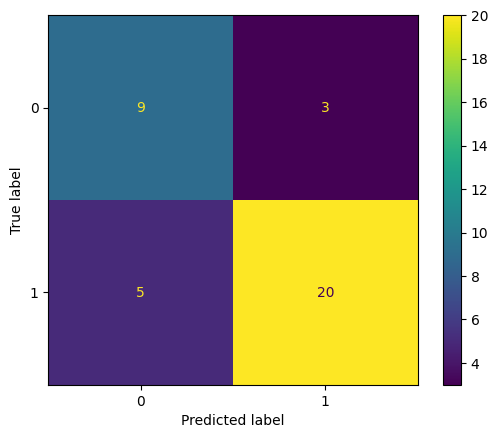

In [496]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_predicted)

Print a classification report to view precision, recall, and other metrics.

In [497]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.64      0.75      0.69        12
           1       0.87      0.80      0.83        25

    accuracy                           0.78        37
   macro avg       0.76      0.78      0.76        37
weighted avg       0.80      0.78      0.79        37



## Test File

In [498]:
test_url = 'https://github.com/robitussin/CCMACLRL_EXERCISES_OLD/blob/f5fdfba1aabbbafcf2fe49ca6e1c8f92f69d1458/datasets/titanic/test.csv?raw=true'
dt=pd.read_csv(test_url)

In [499]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [500]:
# Apply the same feature engineering
dt['FamilySize'] = dt['SibSp'] + dt['Parch'] + 1
dt['IsAlone'] = (dt['FamilySize'] == 1).astype(int)
dt['Title'] = dt['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
dt['Title'] = dt['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 
                                   'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dt['Title'] = dt['Title'].replace(['Mlle', 'Ms'], 'Miss')
dt['Title'] = dt['Title'].replace('Mme', 'Mrs')

# Encode Title
dt = pd.get_dummies(dt, columns=['Title'])

# Encode Sex and Pclass
dt = pd.get_dummies(dt, columns=["Sex", "Pclass"])

# Select the same features as training
features = [col for col in df.columns if col != 'Survived']
dt = dt[features]

<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:4: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_31135/1838219996.py:4: SyntaxWarning: invalid escape sequence '\.'
  dt['Title'] = dt['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


## Sample Submission File

In [501]:
sample_submission_url ='https://github.com/robitussin/CCMACLRL_EXERCISES_OLD/blob/f5fdfba1aabbbafcf2fe49ca6e1c8f92f69d1458/datasets/titanic/gender_submission.csv?raw=true'

sf=pd.read_csv(sample_submission_url)

In [502]:
sf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB


## Generate Results

In [503]:
# Fill missing values in test data with column means
dt_filled = dt.fillna(dt.mean(numeric_only=True))

y_pred = log_model.predict(dt_filled)

# Create a submission DataFrame
submission_df = pd.DataFrame({
    'PassengerId': id,
    'Survived': y_pred
})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission_file.csv', index=False)
print("Submission file created: submission_file.csv")

Submission file created: submission_file.csv
